# Lecture 21: Class demo (Based on the lecture notes)

UBC 2025-26

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os 
sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
from plotting_functions import *

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import log_loss
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")
plt.rcParams["font.size"] = 12

<br><br>

## Visualizing your results

- Very powerful but at the same time can be misleading if not done properly. 

Pre-viewing review from [Calling BS visualization videos](https://www.youtube.com/watch?v=T-5aLbNeGo0&list=PLPnZfvKID1Sje5jWxt-4CSZD7bUI4gSPS&index=30&t=0s):

- Dataviz in the popular media.
  - e.g. [modern NYT](https://youtu.be/T-5aLbNeGo0?t=367)
- Misleading axes.
  - e.g. [vaccines](https://youtu.be/9pNWVMxaFuM?t=299)
- Manipulating bin sizes.
  - e.g. [tax dollars](https://youtu.be/zAg1wsYfwsM?t=196)
- Dataviz ducks.
  - e.g. [drinking water](https://youtu.be/rmii1hfP6d4?t=169)
  - "look how clever we are about design" -> making it about me instead of about you (see last class)
- Glass slippers.
  - e.g. [internet marketing tree](https://youtu.be/59teS0SUHtI?t=285)
- The principle of proportional ink.
  - e.g. [most read books](https://youtu.be/oNhusd3xFC4?t=147)

- [Demo of cleaning up a plot](https://www.darkhorseanalytics.com/blog/data-looks-better-naked)
- [Principle of proportional ink](https://serialmentor.com/dataviz/proportional-ink.html) from a viz textbook.

### Dataset

We'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), which we used in lecture 10. As usual, to run this notebook you'll need to download the data. For this dataset, train and test have already been separated. We'll be working with the train portion. 

In [2]:
df = pd.read_csv(DATA_DIR + "housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


In [3]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [4]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

### Feature types 

- We have mixed feature types and a bunch of missing values. 
- Now, let's identify feature types and transformations. 

In [5]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [6]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [7]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ["NA", "No", "Mn", "Av", "Gd"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
]

The remaining features are categorical features.

In [8]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)
    - set(drop_features)
)
categorical_features

['CentralAir',
 'MoSold',
 'LandSlope',
 'Alley',
 'Neighborhood',
 'Utilities',
 'LotConfig',
 'GarageFinish',
 'MasVnrType',
 'SaleCondition',
 'Heating',
 'Electrical',
 'BldgType',
 'LotShape',
 'HouseStyle',
 'LandContour',
 'RoofStyle',
 'SaleType',
 'RoofMatl',
 'Foundation',
 'PavedDrive',
 'MSSubClass',
 'Street',
 'Exterior2nd',
 'Exterior1st',
 'MSZoning',
 'Condition2',
 'GarageType',
 'Condition1',
 'MiscFeature']

### Applying feature transformations

- Since we have mixed feature types, let's use `ColumnTransformer` to apply different transformations on different features types.  

In [9]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

### Examining the preprocessed data

In [10]:
preprocessor.fit(X_train)
# Calling fit to examine all the transformers.

ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['BedroomAbvGr', 'KitchenAbvGr', 'LotFrontage',
                                  'LotArea', 'OverallQual', 'OverallCond',
                                  'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '...
                                 ['CentralAir', 'MoSold', 'LandSlope', 'Alley',
                                  'Neighborhood', 'Utilities', 'LotConfig',
                                  'GarageFinish', 'MasVnrType', 'SaleCondition',
                                  'Heating', 'Electrical', 'BldgType',
                                  'LotShape', 'HouseStyle', 'LandContour',
                                  'RoofStyle', 'SaleType', 'RoofMatl',
                                  'Foundation', 'PavedDrive', 'MSSubClass',
                                  'Street', 'Exterior2nd', 'Exterior1st',
                                  'MSZoning', 'Condition2', 'GarageType',
                                  'Condition1', 'MiscFeature'])])

In [11]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns
)

In [12]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_missing
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
X_test_enc = pd.DataFrame(
    preprocessor.transform(X_test), index=X_test.index, columns=new_columns
)
X_test_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_missing
147,0.154795,-0.222647,-0.025381,-0.085415,0.663680,-0.512408,0.993969,0.792023,0.438592,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
676,1.372763,4.348569,-0.454788,-0.074853,-1.491366,-3.209221,-2.351883,-1.679877,-0.573129,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1304,0.154795,-0.222647,-1.790721,-0.768279,0.663680,-0.512408,1.093350,0.937429,0.084490,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1372,0.154795,-0.222647,0.260890,-0.058176,0.663680,0.386530,0.894587,0.646617,-0.573129,1.162214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1427,0.154795,-0.222647,-0.454788,0.073016,-0.773017,0.386530,-0.861157,-1.679877,-0.573129,0.301838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
X_train.shape, X_test.shape

((1314, 80), (146, 80))

### Training random forests and gradient boosted trees

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

Let's compare sklearn's `GradientBoostingRegressor` to `RandomForestRegressor` for different values of `n_estimators`.

In [16]:
n_estimators_values = [3, 10, 30, 100, 300]

In [17]:
score_rf_train = list()
score_rf_test = list()
score_gb_train = list()
score_gb_test = list()

for n_estimators in n_estimators_values:
    print(n_estimators)
    rf = TransformedTargetRegressor(
        RandomForestRegressor(n_estimators=n_estimators, random_state=123),
        func=np.log1p,
        inverse_func=np.expm1,
    )
    rf.fit(X_train_enc, y_train)
    score_rf_train.append(rf.score(X_train_enc, y_train))
    score_rf_test.append(rf.score(X_test_enc, y_test))

    gb = TransformedTargetRegressor(
        GradientBoostingRegressor(n_estimators=n_estimators, random_state=123),
        func=np.log1p,
        inverse_func=np.expm1,
    )
    gb.fit(X_train_enc, y_train)
    score_gb_train.append(gb.score(X_train_enc, y_train))
    score_gb_test.append(gb.score(X_test_enc, y_test))

3
10
30
100
300


### Confusing and perhaps misleading visualization of results

Here is a low-quality plot that is confusing and perhaps downright misleading:

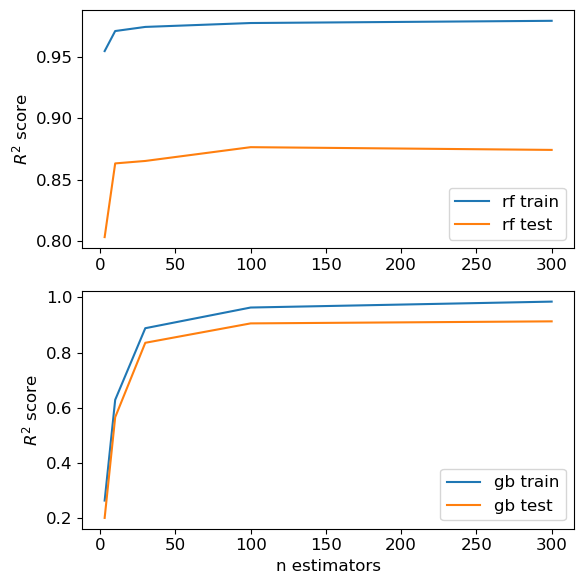

In [18]:
plt.figure(figsize=(6,6));
plt.subplot(2, 1, 1)
plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values, score_rf_test, label="rf test")
plt.ylabel("$R^2$ score")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values, score_gb_test, label="gb test")
plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.legend()
plt.tight_layout();

Could you create some visualizations such that it makes

- RF look better than GB
- GB look better than RF
- RF and GB look equally good

You can create your own misleading example and copy or screenshot it and paste it into [this Google document](https://docs.google.com/document/d/1Nqpcx4yHuVhyrDFrpxbBnduoJC4VFnvVybqzIA1aUmM/edit?usp=sharing).

<br><br><br><br><br><br><br><br>

Here are some misleading plots. 

### RF better than GB

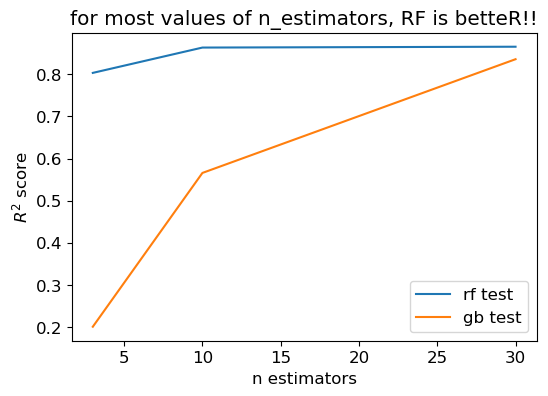

In [19]:
plt.figure(figsize=(6,4))
nmax = 3

# plt.plot(n_estimators_values[:nmax], score_rf_train[:nmax], label="rf train")
plt.plot(n_estimators_values[:nmax], score_rf_test[:nmax], label="rf test")
# plt.plot(n_estimators_values[:nmax], score_gb_train[:nmax], label="gb train")
plt.plot(n_estimators_values[:nmax], score_gb_test[:nmax], label="gb test")
plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.legend()
plt.title("for most values of n_estimators, RF is betteR!!");

### GB better than RF

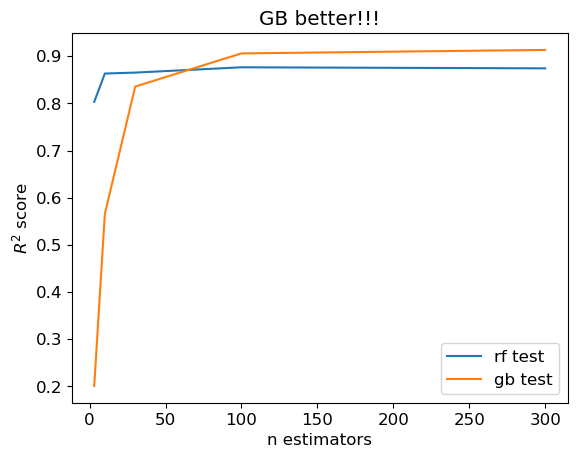

In [20]:
plt.plot(n_estimators_values, score_rf_test, label="rf test")
plt.plot(n_estimators_values, score_gb_test, label="gb test")
plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.legend()
plt.title("GB better!!!");

### Equally good

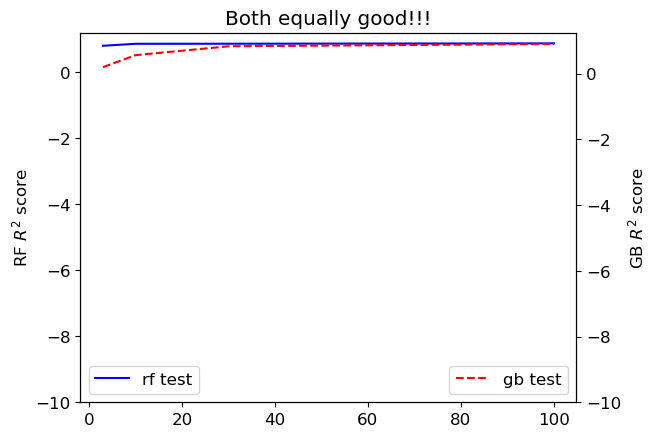

In [21]:
nmax = 4

# plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values[:nmax], score_rf_test[:nmax], "b", label="rf test")
plt.ylabel("RF $R^2$ score")
plt.ylim((-10, 1.2))
plt.legend(loc=0)
plt.twinx()
# plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values[:nmax], score_gb_test[:nmax], "--r", label="gb test")
plt.legend(loc=4)
plt.xlabel("n estimators")
plt.ylabel("GB $R^2$ score")
plt.ylim((-10, 1.25))
#plt.ylim((-0.01, 0.70))
plt.title("Both equally good!!!");

### Things to watch out for

- Chopping off the x-axis
    - the practice of starting the x-axis (or sometimes the y-axis) at a value other than zero to exaggerate the changes in the data   
- Saturate the axes
    - where the axes are set to ranges that are too narrow or too wide for the data being presented making it difficult to identify patterns
- Bar chart for a cherry-picked values
- Different y-axes

**Be critical of your visualizations and try to make them as honest as possible.**

<br><br>